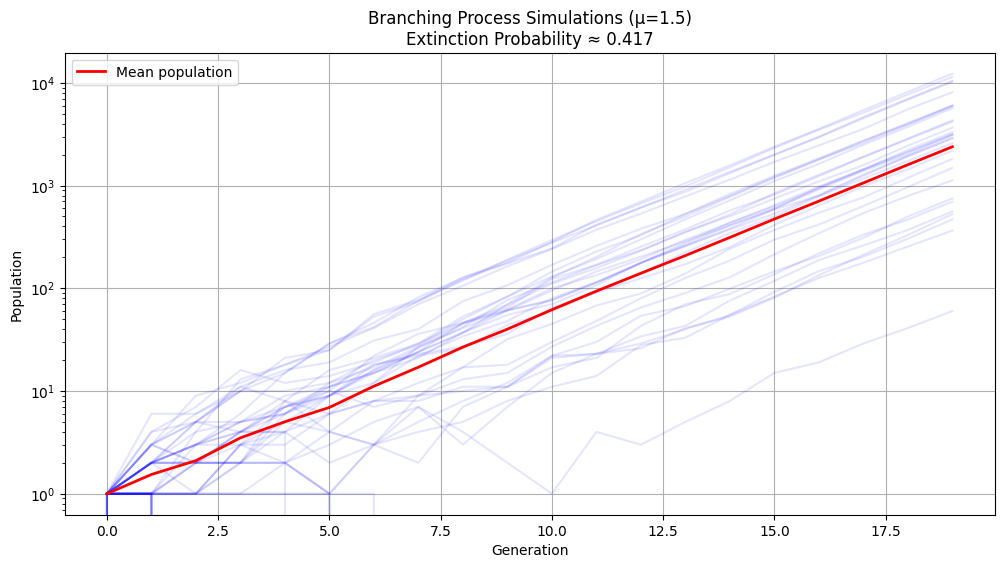

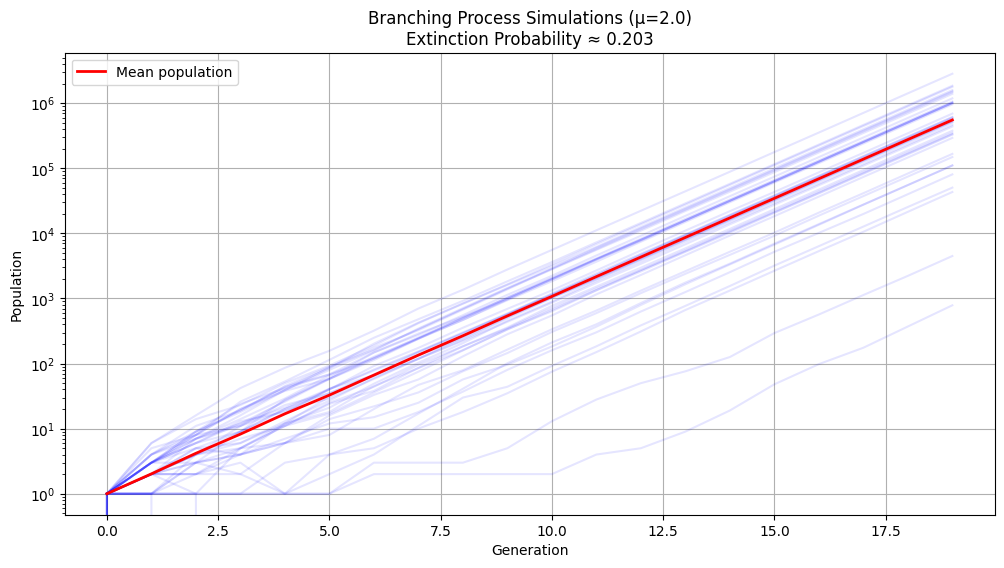

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

class BranchingProcess:
    def __init__(self, offspring_distribution, mu, sigma):
        self.dist = offspring_distribution
        self.mu = mu
        self.sigma = sigma
    
    def simulate_generations(self, n_generations, n_simulations=1):
        """Simulate branching process for n generations multiple times."""
        all_populations = np.zeros((n_simulations, n_generations))
        
        for sim in range(n_simulations):
            population = [1]  # Start with 1 individual
            
            for gen in range(n_generations-1):
                current_pop = population[-1]
                if current_pop == 0:
                    population.append(0)
                else:
                    # Generate offspring for each individual
                    offspring = sum(self.dist.rvs(size=current_pop))
                    population.append(offspring)
            
            all_populations[sim] = population
            
        return all_populations
    
    def calculate_pgf(self, t):
        """Calculate probability generating function at point t."""
        # For Poisson distribution
        return np.exp(self.mu * (t - 1))
    
    def find_extinction_probability(self):
        """Find numerical solution for extinction probability."""
        if self.mu <= 1:
            return 1.0
        
        # Use theoretical upper bound as initial guess
        d_star = 1 - 2*(self.mu-1)/(self.sigma**2 + self.mu**2 - self.mu)
        
        # Simple fixed-point iteration
        t = d_star
        for _ in range(100):
            t_new = self.calculate_pgf(t)
            if abs(t_new - t) < 1e-10:
                break
            t = t_new
        
        return t

# Example usage
def plot_simulations(mu=1.5):
    # Create Poisson distribution with mean mu
    offspring_dist = poisson(mu)
    sigma = mu  # For Poisson, variance equals mean
    
    bp = BranchingProcess(offspring_dist, mu, sigma)
    
    # Simulate multiple paths
    n_gens = 20
    n_sims = 50
    populations = bp.simulate_generations(n_gens, n_sims)
    
    # Calculate extinction probability
    d = bp.find_extinction_probability()
    
    # Plotting
    plt.figure(figsize=(12, 6))
    
    # Plot individual paths
    for i in range(n_sims):
        plt.plot(range(n_gens), populations[i], 'b-', alpha=0.1)
    
    # Plot mean path
    mean_pop = populations.mean(axis=0)
    plt.plot(range(n_gens), mean_pop, 'r-', linewidth=2, label='Mean population')
    
    plt.title(f'Branching Process Simulations (μ={mu})\nExtinction Probability ≈ {d:.3f}')
    plt.xlabel('Generation')
    plt.ylabel('Population')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    
    return plt.gcf()

if __name__ == "__main__":
    # Plot for different values of μ
    plot_simulations(mu=1.5)
    plot_simulations(mu=2.0)

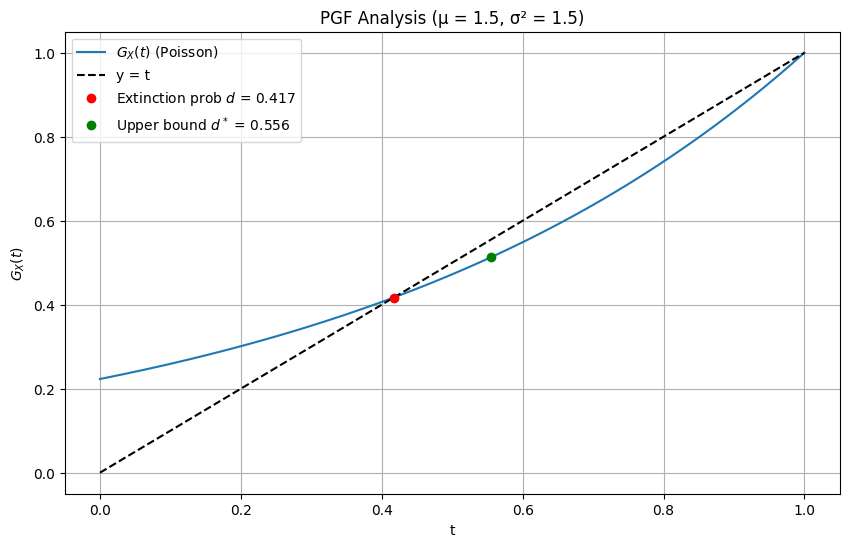

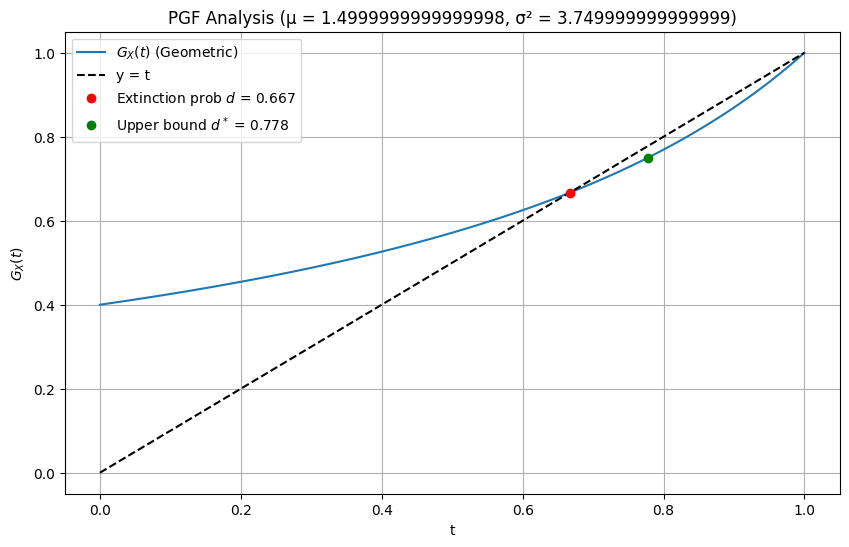

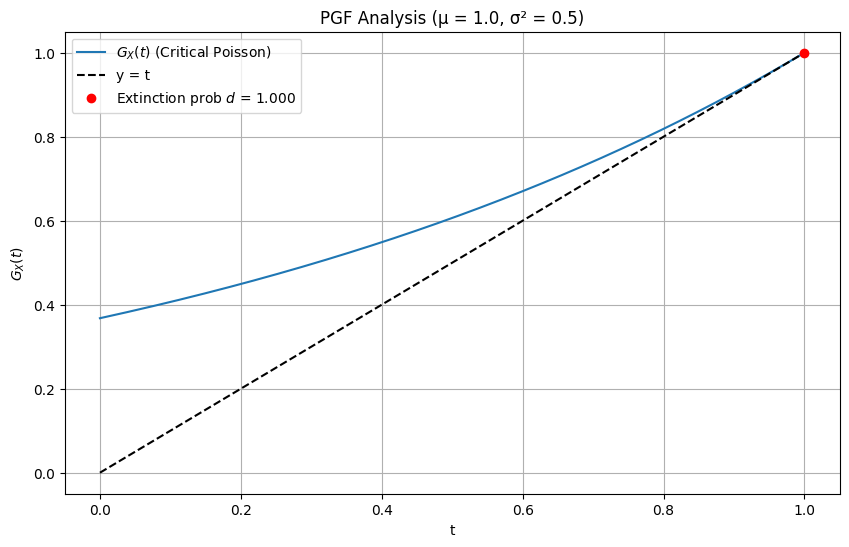

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# ======================
# PART 1: PGF Definitions
# ======================

def pgf_poisson(t, mu):
    """PGF for Poisson distribution (μ = σ²)"""
    return np.exp(mu*(t-1))

def pgf_geometric(t, p):
    """PGF for geometric distribution (σ² = (1-p)/p²)"""
    return p / (1 - (1-p)*t)

# =============================
# PART 2: Extinction Probability
# =============================

def find_extinction_prob(pgf_func, mu, initial_guess=0.5):
    """Numerically solve t = G_X(t) for extinction probability"""
    def equation(t):
        return pgf_func(t) - t
    
    # Different initial guesses for μ > 1 vs μ ≤ 1
    if mu > 1:
        d = fsolve(equation, initial_guess)[0]
    else:  # Almost sure extinction if μ ≤ 1
        d = 1.0
    return d

# ==========================
# PART 3: Upper Bound Formula
# ==========================

def upper_bound_dstar(mu, sigma2):
    """Calculate the upper bound from part (d)"""
    if mu <= 1:
        return 1.0
    denominator = sigma2 + mu**2 - mu
    return 1 - 2*(mu - 1)/denominator

# ======================
# PART 4: Visualization
# ======================

def plot_pgf(pgf_func, mu, sigma2, distribution_name):
    t_values = np.linspace(0, 1, 500)
    pgf_values = pgf_func(t_values)
    
    # Find extinction probability and upper bound
    d = find_extinction_prob(pgf_func, mu)
    d_star = upper_bound_dstar(mu, sigma2)
    
    plt.figure(figsize=(10, 6))
    
    # Plot PGF and identity line
    plt.plot(t_values, pgf_values, label=f'$G_X(t)$ ({distribution_name})')
    plt.plot(t_values, t_values, 'k--', label='y = t')
    
    # Mark critical points
    plt.plot(d, pgf_func(d), 'ro', label=f'Extinction prob $d$ = {d:.3f}')
    if mu > 1:
        plt.plot(d_star, pgf_func(d_star), 'go', 
                label=f'Upper bound $d^*$ = {d_star:.3f}')
    
    plt.title(f'PGF Analysis (μ = {mu}, σ² = {sigma2})')
    plt.xlabel('t')
    plt.ylabel('$G_X(t)$')
    plt.legend()
    plt.grid(True)
    plt.show()

# ===========================
# EXAMPLE 1: Poisson Distribution
# ===========================
mu_poisson = 1.5
sigma2_poisson = mu_poisson  # Poisson property
plot_pgf(lambda t: pgf_poisson(t, mu_poisson),
        mu_poisson, sigma2_poisson,
        "Poisson")

# ==============================
# EXAMPLE 2: Geometric Distribution
# ==============================
p_geo = 0.4
mu_geo = (1-p_geo)/p_geo
sigma2_geo = (1-p_geo)/(p_geo**2)
plot_pgf(lambda t: pgf_geometric(t, p_geo),
        mu_geo, sigma2_geo,
        "Geometric")

# ====================================
# EXAMPLE 3: Critical Case (μ = 1)
# ====================================
mu_critical = 1.0
sigma2_critical = 0.5
plot_pgf(lambda t: pgf_poisson(t, mu_critical),
        mu_critical, sigma2_critical,
        "Critical Poisson")